In [15]:
#https://www.datacamp.com/tutorial/langgraph-tutorial

In [2]:
import os
import getpass
import requests
from ibm_watsonx_ai import APIClient
from langchain_ibm import ChatWatsonx

project_id="2adbc31f-5dc4-4e42-b730-1e5e360727fd"
url="https://us-south.ml.cloud.ibm.com"
apikey="0cZb46prORvZpwwPng_oLDJOxt5SmJwRqzw0gAfZKJ5_"


parameters = {
    "frequency_penalty": 0,
    "max_tokens": 2000,
    "presence_penalty": 0,
    "temperature": 0,
    "top_p": 1
}

model_id = "ibm/granite-3-8b-instruct"

chat_model = ChatWatsonx(
    model_id=model_id,
    url=url,
    apikey=apikey,
    project_id=project_id,
    params=parameters,
)

chat_model.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 60, 'total_tokens': 70}, 'model_name': 'ibm/granite-3-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'stop'}, id='chatcmpl-c83183edb214f47c31c6d3afbae8100e', usage_metadata={'input_tokens': 60, 'output_tokens': 10, 'total_tokens': 70})

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [72]:
class State(TypedDict):
    # messages have the type "list".
    # The add_messages function appends messages to the list, rather than overwriting them
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    print("****", state, "****")
    return {"messages": [chat_model.invoke(state["messages"])]}


In [73]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

In [74]:
# Set entry and finish points
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

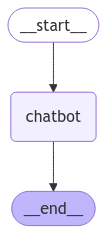

In [75]:
graph = graph_builder.compile()
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [76]:
for i in range( 0 ,3 ):
    print(i)

    user_input = input("User: ")
    input_to_graph = {"messages": [{"role": "user", "content": user_input}]}

    ai_reponse = graph.invoke ( input_to_graph)
    print(ai_reponse['messages'][-1].content)

0
**** {'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='b89dd6d6-82a5-4354-990a-c3ebafadf27b')]} ****
Hello! How can I assist you today? I'm here to provide concise and accurate information. Let's get started.
1
**** {'messages': [HumanMessage(content='who are you', additional_kwargs={}, response_metadata={}, id='c7512bfb-594e-4bb0-88e5-2bdeb49a7f6c')]} ****
I am Granite, an AI developed by IBM Research—a research organization spread across the globe. I am designed to provide information and assistance across a wide range of topics. My responses are generated based on a vast amount of data I've been trained on, up until April 2024.
2
**** {'messages': [HumanMessage(content='what is the weather in charlotte nc', additional_kwargs={}, response_metadata={}, id='be6b67ea-f613-45aa-beea-3758e30b2e31')]} ****
As of now, the weather in Charlotte, NC is mostly cloudy with a temperature of approximately 50°F (10°C). Please check a reliable weather source 

In [70]:
# Run the chatbot
#while True:
for i in range( 0 ,5 ):

    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")

    u= graph.invoke ( {"messages": [("user", user_input)]})
    print("Assistant:", u["messages"][-1].content)
    #for event in graph.stream({"messages": [("user", user_input)]}):
        #for value in event.values():
            #print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today? I'm here to provide concise and accurate information. Let's get started.
Assistant: I'm sorry for any confusion, but as an artificial intelligence, I don't have the ability to know personal details about individuals unless they've been shared with me in the course of our conversation. I'm designed to respect user privacy and confidentiality. Therefore, I don't have information about who you are. I'm here to provide information and answer questions to the best of my ability.
Assistant: The concept of "age of the skies" isn't a standard term in astronomy or cosmology. If you're asking about the age of the universe, it's estimated to be around 13.8 billion years old, based on observations of the cosmic microwave background radiation and the rate of expansion of the universe. This age represents the time since the Big Bang, the event that marked the beginning of our universe.

If you're asking about the age of celestial bodies like stars or pla

# exampl2 2

In [7]:
model_id="meta-llama/llama-3-3-70b-instruct"

chat_model = ChatWatsonx(
    model_id=model_id,
    url=url,
    apikey=apikey,
    project_id=project_id,
    params=parameters,
)

In [8]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool

# Define the tools for the agent to use
@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        u="0 degrees / rainy / polluted."
    else:
        u = "-10 degrees / sunny"
    print("***",u,"***")
    return u


tools = [search]

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

app = create_react_agent(chat_model, tools, checkpointer=checkpointer)

# Use the agent
final_state = app.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

*** 0 degrees / rainy / polluted. ***


'The weather in SF is 0 degrees, rainy, and polluted.'

In [9]:
final_state = app.invoke(
    {"messages": [{"role": "user", "content": "what about ny"}]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

*** -10 degrees / sunny ***


'The weather in NY is -10 degrees and sunny.'

In [10]:
final_state

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='2116de3d-864c-4186-9a7b-abc21d524fba'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-a7fc14e318d9492083821ebaef2babd7', 'type': 'function', 'function': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 239, 'total_tokens': 263}, 'model_name': 'meta-llama/llama-3-3-70b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-4b1fcd32f5455264d64966920989bada', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'chatcmpl-tool-a7fc14e318d9492083821ebaef2babd7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 239, 'output_tokens': 24, 'total_tokens': 263}),
  ToolMessage(content='0 degrees / rainy / polluted.', name='search', id='afad4690-2e9b-4909-a2d5-54b6539a817b', tool_call_id='chatcmpl-tool-a7fc14

In [6]:
final_state["messages"][-1]

AIMessage(content='', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 263, 'total_tokens': 264}, 'model_name': 'ibm/granite-3-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'stop'}, id='chatcmpl-ebe576000dfb4c84afce6f6d2243b5fa', usage_metadata={'input_tokens': 263, 'output_tokens': 1, 'total_tokens': 264})